<a href="https://colab.research.google.com/github/mrarat76/Tensorflow_Practises/blob/main/Tensor_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tensorflow, Transfer Learning ile Fine-Tuning

In [ ]:

import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.14.0


In [ ]:
!nvidia-smi

Sat Nov 25 22:22:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Helper fonksiyonların oluşturulması

Bu fonksiyonlar tekrar tekrar kullanmak istediğin kodları tekrardan yazmaman için kullanılan fonksiyonlardır.

In [ ]:
# helper_functions.py scriptini GitHubdan çekiyoruz.
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# helper fonksiyonunu import ettiriyoruz
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-11-25 22:25:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-25 22:25:33 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
## İlk etapta 10 adet yiyecek classını içeren az veriye sahip datayla çalışacağız.

# Datanın %10nunu alıyoruz.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2023-11-25 22:26:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   209MB/s    in 0.8s    

2023-11-25 22:26:34 (209 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#İnceliyoruz.
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Train ve test directoryleri değişkenlere atıyoruz.
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Data imputları oluşturuyoruz.
import tensorflow as tf
IMG_SIZE = (224, 224) # resim boyutunu tanımlıyoruz
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # etiketlerin cinsi
                                                                            batch_size=32) # batch_size varsayılan olarak 32 olarak ayarlandı.İyi bir sayı olduğu aşikar.
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Train datasının tipini kontrol ediyoruz.
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


Yukarıdaki çıktıda:

(None, 224, 224, 3), görüntülerimizin tensör şeklini temsil eder, burada None, grup boyutunu ifade ederken, 224 yükseklik (ve genişlik) ve 3 renk kanalını (kırmızı, yeşil, mavi) belirtir.
(None, 10), etiketlerin tensör şeklini temsil eder, burada None, grup boyutunu ifade ederken, 10 ise olası etiketlerin sayısını (10 farklı yemek sınıfı) belirtir.
Görüntü tensörleri ve etiketler, tf.float32 veri türündedir.
None olan batch_size, yalnızca model eğitimi sırasında kullanıldığı için vardır. None'yi, image_dataset_from_directory() işlevinden alınan batch_size parametresi ile doldurulmayı bekleyen bir yer tutucu olarak düşünebilirsiniz.

tf.data.Dataset API kullanmanın başka bir avantajı da onunla birlikte gelen ilişkili yöntemlerdir.

Örneğin, çalıştığımız sınıfların adını bulmak istiyorsak, class_names özniteliğini kullanabiliriz.







In [ ]:
# Datanın batchinden bir örnek görelim
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.65867348e+01 8.58673477e+00 0.00000000e+00]
   [2.73571434e+01 9.35714245e+00 0.00000000e+00]
   [2.83571434e+01 1.03571424e+01 0.00000000e+00]
   ...
   [2.02413269e+02 2.11561234e+02 2.21275528e+02]
   [2.06637741e+02 2.16637741e+02 2.25994888e+02]
   [2.04928574e+02 2.14928574e+02 2.24285721e+02]]

  [[2.90714283e+01 1.10714283e+01 0.00000000e+00]
   [2.99336739e+01 1.19336739e+01 0.00000000e+00]
   [3.00000000e+01 1.20000000e+01 0.00000000e+00]
   ...
   [2.02989883e+02 2.11387802e+02 2.22188843e+02]
   [2.03367310e+02 2.11367310e+02 2.22367310e+02]
   [2.02316437e+02 2.10316437e+02 2.21316437e+02]]

  [[3.00000000e+01 1.20000000e+01 0.00000000e+00]
   [2.92704086e+01 1.12704077e+01 0.00000000e+00]
   [2.92142868e+01 1.12142859e+01 0.00000000e+00]
   ...
   [2.02571426e+02 2.11357147e+02 2.20785721e+02]
   [1.97928558e+02 2.04357132e+02 2.16142838e+02]
   [2.05780884e+02 2.12209457e+02 2.23995163e+02]]

  ...

  [[2.42858887e+00 0.00000000e+00 1.00000000e+00]
   [3

##Model 0: Transfer Learning Modeli Keras APIsi ile yapılması


Aşağıdaki adımları takip edeceğiz:

tf.keras.applications.efficientnet_v2 gibi bir hedef model seçerek önceden eğitilmiş bir temel model nesnesini oluşturun. include_top parametresini False olarak ayarlarız (bunu yapmamızın nedeni, model için kendi üst katmanımızı oluşturacağımız için, bu üst katman modelin çıkış katmanlarıdır).

Temel modelin trainable özniteliğini False olarak ayarlayarak önceden eğitilmiş modelin tüm ağırlıklarını dondurun.

Modelimiz için bir giriş katmanı tanımlayın; örneğin, modelimizin hangi veri şeklini beklemesi gerekiyor?

[İsteğe bağlı] Modelimize girişleri normalize edin, eğer gerekiyorsa. Bazı görüntü işleme modelleri, örneğin ResNetV250 gibi, girişlerinin 0 ile 1 arasında olmasını gerektirir.


Girişleri temel modele iletilir.

Temel modelin çıktılarını çıkış aktivasyon katmanı ile uyumlu bir şekle (temel model çıkış tensörlerini etiket tensörleri ile aynı şekle) dönüştürün. Bu işlem, tf.keras.layers.GlobalAveragePooling2D() veya tf.keras.layers.GlobalMaxPooling2D() kullanılarak yapılabilir, ancak özellikle pratikte daha yaygın olarak kullanılanı ilk seçenektir.

Uygun aktivasyon fonksiyonu ve nöron sayısı ile tf.keras.layers.Dense() kullanarak bir çıkış aktivasyon katmanı oluşturun.

Giriş ve çıkış katmanlarını tf.keras.Model() kullanarak birleştirerek bir model oluşturun.

Modeli uygun kayıp fonksiyonu ve bir optimizatör seçerek derleyin.

Modeli istediğiniz sayıda dönem için ve gerekli geriçağırıcılarla (bizim durumumuzda TensorBoard geriçağırıcısı ile başlayacağız) uygun şekilde eğitin.

In [ ]:
# 1. Keras ile model oluşturma
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Modelin Dondurulması
base_model.trainable = False

# 3. Modele verilecek inputların oluşturulması.
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. ResNet50V2 kullanıyorsanız yakınsamayı hızlandırmak için bunu ekleyin, EfficientNetV2 için kaldırın
 # x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(girişler)

# 5. Inputların base_model'e iletilmesi (not: tf.keras.applications kullanıldığında EfficientNetV2 girişlerinin normalleştirilmesine gerek yoktur)
x = base_model(inputs)
# Veri şeklini base_model'e aktardıktan sonra kontrol edilmesi
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Çıkış etkinleştirme katmanını oluşturun

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Girdileri çıktılarla bir modelde birleştirin

model_0 = tf.keras.Model(inputs, outputs)

# 9. Modelin derlenmesi
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Modelin fitlenmesi
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20231125-224107
Epoch 1/5
24/24 [==============================] - 25s 301ms/step - loss: 1.8969 - accuracy: 0.4093 - val_loss: 1.3445 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 5s 189ms/step - loss: 1.1553 - accuracy: 0.7587 - val_loss: 0.9075 - val_accuracy: 0.8092
Epoch 3/5
24/24 [==============================] - 4s 174ms/step - loss: 0.8247 - accuracy: 0.8253 - val_loss: 0.7354 - val_accuracy: 0.8257
Epoch 4/5
24/24 [==============================] - 4s 173ms/step - loss: 0.6818 - accuracy: 0.8547 - val_loss: 0.6448 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 5s 189ms/step - loss: 0.5901 - accuracy: 0.8613 - val_loss: 0.5821 - val_accuracy: 0.8487


In [ ]:
# Modelimizdeki layerları kontrol ediyoruz
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
base_model.summary()


Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
model_0.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

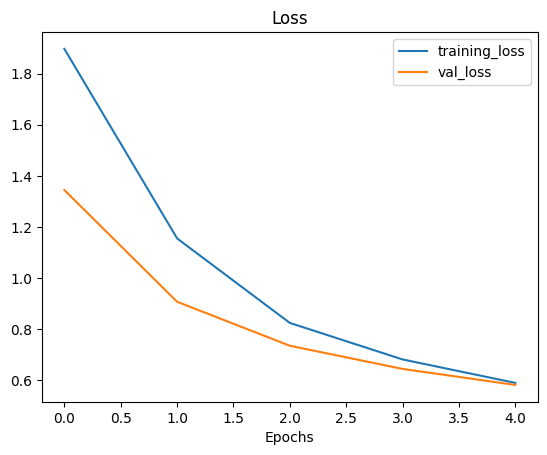

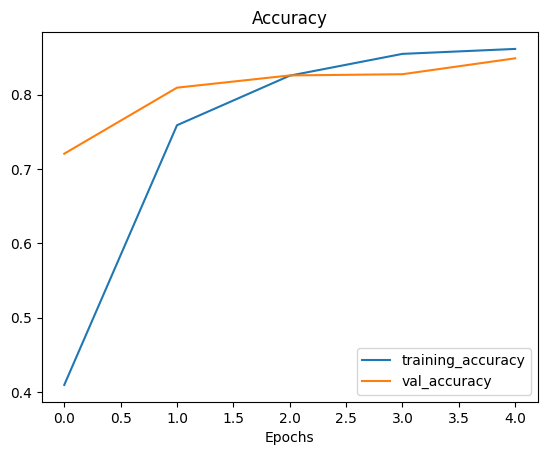

In [ ]:
plot_loss_curves(history_10_percent)


# Eğitilmiş bir modelden feature vector alma
tf.keras.layers.GlobalAveragePooling2D() katmanı, iç eksenlerdeki değerlerin ortalamasını alarak bir 4D tensörü 2D tensöre dönüştürür.


In [ ]:

# GİRİŞ TENSORLERİNİN TANIMLANMASI ( efficientnetv2-b0 çıktısının aynısı)
input_shape = (1, 4, 4, 3)

# Random bir tensor oluşturulması
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#Rastgele tensörü  global average pooling 2B katmanından geçirin
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Farklı tensörlerin şekillerini kontrol edin

print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Bu işlem, temel modelin çıktısını sadece çıkış katmanımızın (tf.keras.layers.Dense()) giriş şekil gereksinimleriyle uyumlu hale getirmekle kalmaz, aynı zamanda temel model tarafından bulunan bilgiyi daha düşük boyutlu bir özellik vektörüne yoğunlaştırır.

 Not: Özellik çıkarma transfer öğrenme bu adıyla adlandırılıyor çünkü genellikle önceden eğitilmiş bir model, bir özellik vektörü (uzun bir sayılar tensörü, bizim durumumuzda bu, tf.keras.layers.GlobalAveragePooling2D() katmanının çıktısıdır) çıkarır ve bu vektörü desenlerin çıkarılması için kullanabilirsiniz.

 Pratik: Yukarıdaki hücrede olduğu gibi aynı işlemi tf.keras.layers.GlobalMaxPool2D() için yapın.





